In [6]:
from pathlib import Path
import json

from datasets import load_dataset
BASE_DIR = Path("/home/lfy/BRIDGE/IRT")

def read_jsonl(path: Path):
    """Load every JSON line into a list of dicts."""
    with path.open() as f:
        return [json.loads(line) for line in f]

def select_score(value):
    if isinstance(value, dict):
        for key in ("any_medal", "valid_submission", "above_median"):
            if key in value:
                return value[key]
        raise ValueError(f"Unable to pick score from {value}")
    return value

def build_score_matrix(records):
    required = {"id", "model_name", "score"}
    for idx, record in enumerate(records):
        missing = required - record.keys()
        if missing:
            raise ValueError(f"Record {idx} is missing fields: {missing}")
    ids = sorted({record["id"] for record in records})
    models = sorted({record["model_name"] for record in records})
    id_to_idx = {rid: idx for idx, rid in enumerate(ids)}
    model_to_idx = {name: idx for idx, name in enumerate(models)}
    matrix = [[float("nan") for _ in models] for _ in ids]
    for record in records:
        row = id_to_idx[record["id"]]
        col = model_to_idx[record["model_name"]]
        matrix[row][col] = select_score(record["score"])
    return {"ids": ids, "models": models, "array": matrix}

def load_verified_difficulties(dataset_id="princeton-nlp/SWE-bench_Verified", split="test"):
    dataset = load_dataset(dataset_id, split=split)
    return {row["instance_id"]: row.get("difficulty") for row in dataset}

swe_results = read_jsonl(BASE_DIR / "swebench_results.jsonl")
mle_results = read_jsonl(BASE_DIR / "mlebench_results.jsonl")

# U
swe_scores = build_score_matrix(swe_results)
mle_scores = build_score_matrix(mle_results)

# M
print(f"SWE-bench: {len(swe_scores['ids'])} ids x {len(swe_scores['models'])} models")
print("SWE models (M):", swe_scores["models"])
print(f"MLE-bench: {len(mle_scores['ids'])} ids x {len(mle_scores['models'])} models")
print("MLE models (M):", mle_scores["models"])

difficulty_lookup = load_verified_difficulties()
swe_difficulty = [difficulty_lookup.get(task_id) for task_id in swe_scores["ids"]]
missing = sum(d is None for d in swe_difficulty)
print("Missing difficulties:", missing)
difficulty_levels = [ '<15 min fix', '15 min - 1 hour', '1-4 hours', '>4 hours']
difficulty_to_int = {label: idx + 1 for idx, label in enumerate(difficulty_levels)}
swe_difficulty_ints = [difficulty_to_int.get(label) for label in swe_difficulty]
print("Difficulty mapping:", difficulty_to_int)
print("Example mapped integers:", swe_difficulty_ints[:5])

SWE-bench: 500 ids x 6 models
SWE models (M): ['gpt-oss-120b', 'gpt-oss-20b', 'minimaxm2', 'qwen2_5coder32b', 'qwen3-coder-30b', 'qwen3-coder-480b']
MLE-bench: 37 ids x 5 models
MLE models (M): ['gpt-oss-120b', 'gpt-oss-20b', 'minimaxm2', 'qwen3-coder-30b', 'qwen3coder480']
Missing difficulties: 0
Difficulty mapping: {'<15 min fix': 1, '15 min - 1 hour': 2, '1-4 hours': 3, '>4 hours': 4}
Example mapped integers: [2, 2, 2, 3, 2]


In [2]:
import math

def matrix_to_pyirt_records(scores):
    ids = scores["ids"]
    models = scores["models"]
    arr = scores["array"]
    for col_idx, model in enumerate(models):
        responses = {}
        for row_idx, item in enumerate(ids):
            value = arr[row_idx][col_idx]
            if value is None or isinstance(value, float) and math.isnan(value):
                continue
            responses[item] = int(value)  # py-irt expects binary outcomes
        if responses:
            yield {"subject_id": model, "responses": responses}

def write_pyirt_jsonl(scores, out_path):
    records = list(matrix_to_pyirt_records(scores))
    with open(out_path, "w") as f:
        for record in records:
            f.write(json.dumps(record) + "\n")
    print(f"Wrote {len(records)} subjects to {out_path}")


In [7]:
mle_scores

{'ids': ['AI4Code',
  'aerial-cactus-identification',
  'aptos2019-blindness-detection',
  'billion-word-imputation',
  'cassava-leaf-disease-classification',
  'chaii-hindi-and-tamil-question-answering',
  'champs-scalar-coupling',
  'denoising-dirty-documents',
  'dog-breed-identification',
  'dogs-vs-cats-redux-kernels-edition',
  'google-quest-challenge',
  'histopathologic-cancer-detection',
  'jigsaw-toxic-comment-classification-challenge',
  'jigsaw-unintended-bias-in-toxicity-classification',
  'kuzushiji-recognition',
  'leaf-classification',
  'learning-agency-lab-automated-essay-scoring-2',
  'lmsys-chatbot-arena',
  'mlsp-2013-birds',
  'multi-modal-gesture-recognition',
  'new-york-city-taxi-fare-prediction',
  'nomad2018-predict-transparent-conductors',
  'osic-pulmonary-fibrosis-progression',
  'petfinder-pawpularity-score',
  'plant-pathology-2020-fgvc7',
  'plant-pathology-2021-fgvc8',
  'predict-volcanic-eruptions-ingv-oe',
  'random-acts-of-pizza',
  'ranzcr-clip-cat

In [9]:
write_pyirt_jsonl(swe_scores, BASE_DIR / "swebench_pyirt.jsonl")
write_pyirt_jsonl(mle_scores, BASE_DIR / "mlebench_pyirt.jsonl")


Wrote 6 subjects to /home/lfy/BRIDGE/IRT/swebench_pyirt.jsonl
Wrote 5 subjects to /home/lfy/BRIDGE/IRT/mlebench_pyirt.jsonl


In [12]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 5.3 MB/s eta 0:00:00
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 27.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 14.9 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 22.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.5 MB/s eta 0:00:0000:0100:01
Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)


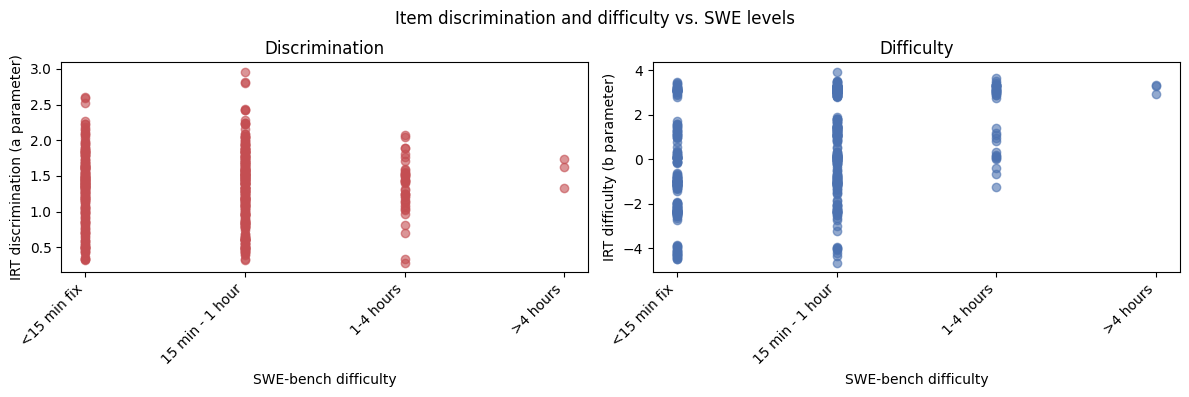

In [23]:
import csv
import matplotlib.pyplot as plt

params_path = BASE_DIR / "params" / "swebench_pyirt.csv"
a_values = []
b_values = []
difficulty_indices = []
with params_path.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        task_id = row[""]
        label = difficulty_lookup.get(task_id)
        diff_value = difficulty_to_int.get(label) if label else None
        if diff_value is None:
            continue
        difficulty_indices.append(diff_value)
        a_values.append(float(row["a"]))
        b_values.append(float(row["b"]))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
plt.suptitle("Item discrimination and difficulty vs. SWE levels")

axes[0].scatter(difficulty_indices, a_values, alpha=0.6, color="#C44E52")
axes[0].set_xticks(list(difficulty_to_int.values()), difficulty_levels, rotation=45, ha="right")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_ylabel("IRT discrimination (a parameter)")
axes[0].set_title("Discrimination")

axes[1].scatter(difficulty_indices, b_values, alpha=0.6, color="#4C72B0")
axes[1].set_xticks(list(difficulty_to_int.values()), difficulty_levels, rotation=45, ha="right")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_ylabel("IRT difficulty (b parameter)")
axes[1].set_title("Difficulty")

plt.tight_layout()
plt.subplots_adjust(top=0.85)



Average discrimination (a) by difficulty:
  <15 min fix: 1.322
  15 min - 1 hour: 1.329
  1-4 hours: 1.349
  >4 hours: 1.564
Average difficulty (b) by difficulty:
  <15 min fix: -0.637
  15 min - 1 hour: 0.712
  1-4 hours: 2.206
  >4 hours: 3.176


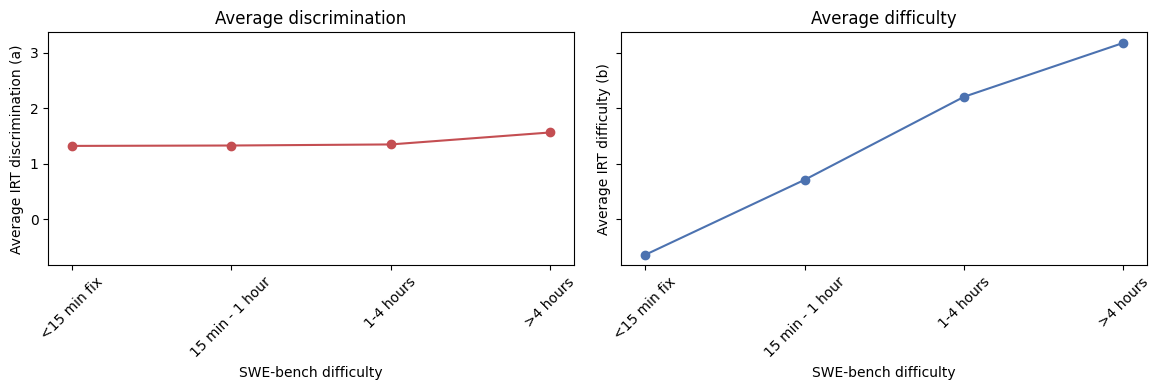

In [25]:
from collections import defaultdict
import csv
import matplotlib.pyplot as plt

params_path = BASE_DIR / "params" / "swebench_pyirt.csv"
a_by_difficulty = defaultdict(list)
b_by_difficulty = defaultdict(list)
with params_path.open() as f:
    reader = csv.DictReader(f)
    for row in reader:
        task_id = row[""]
        label = difficulty_lookup.get(task_id)
        if not label:
            continue
        diff_key = difficulty_to_int.get(label)
        if diff_key is None:
            continue
        a_by_difficulty[label].append(float(row["a"]))
        b_by_difficulty[label].append(float(row["b"]))

ordered_labels = [label for label in difficulty_levels if label in b_by_difficulty]
globals()["a_by_difficulty"] = a_by_difficulty
globals()["b_by_difficulty"] = b_by_difficulty
globals()["ordered_labels"] = ordered_labels

a_averages = [sum(values) / len(values) for values in (a_by_difficulty[label] for label in ordered_labels)]
b_averages = [sum(values) / len(values) for values in (b_by_difficulty[label] for label in ordered_labels)]

print("Average discrimination (a) by difficulty:")
for label, avg in zip(ordered_labels, a_averages):
    print(f"  {label}: {avg:.3f}")

print("Average difficulty (b) by difficulty:")
for label, avg in zip(ordered_labels, b_averages):
    print(f"  {label}: {avg:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
axes[0].plot(ordered_labels, a_averages, marker="o", color="#C44E52")
axes[0].set_ylabel("Average IRT discrimination (a)")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_title("Average discrimination")
axes[0].tick_params(axis="x", rotation=45)

axes[1].plot(ordered_labels, b_averages, marker="o", color="#4C72B0")
axes[1].set_ylabel("Average IRT difficulty (b)")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_title("Average difficulty")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()



Difficulty statistics (variance and 95% CI) for discrimination (a):
  <15 min fix: variance=0.247, mean=1.322 ± 0.070
  15 min - 1 hour: variance=0.264, mean=1.329 ± 0.062
  1-4 hours: variance=0.148, mean=1.349 ± 0.116
  >4 hours: variance=0.043, mean=1.564 ± 0.234
Difficulty statistics (variance and 95% CI) for difficulty (b):
  <15 min fix: variance=4.782, mean=-0.637 ± 0.308
  15 min - 1 hour: variance=4.244, mean=0.712 ± 0.250
  1-4 hours: variance=2.106, mean=2.206 ± 0.439
  >4 hours: variance=0.053, mean=3.176 ± 0.261


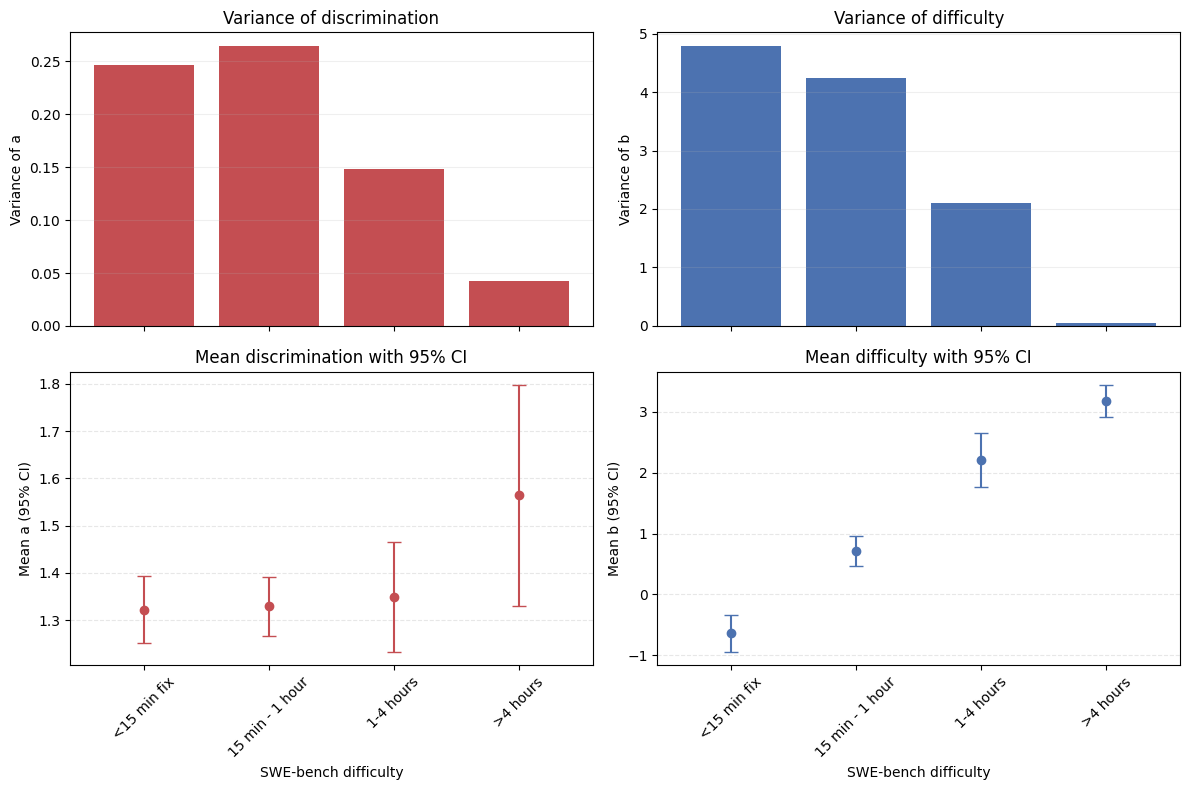

In [26]:
import math
import matplotlib.pyplot as plt

if "a_by_difficulty" not in globals() or "b_by_difficulty" not in globals():
    raise RuntimeError("Run the averaging cell first to build parameter dictionaries")

ordered = globals().get("ordered_labels") or [label for label in difficulty_levels if label in b_by_difficulty]

def compute_stats(param_map):
    stats = []
    for label in ordered:
        values = param_map[label]
        if not values:
            continue
        mean_val = sum(values) / len(values)
        if len(values) > 1:
            variance = sum((v - mean_val) ** 2 for v in values) / (len(values) - 1)
            std_error = math.sqrt(variance / len(values))
        else:
            variance = 0.0
            std_error = 0.0
        ci = 1.96 * std_error
        stats.append((label, mean_val, variance, ci))
    return stats

a_stats = compute_stats(a_by_difficulty)
b_stats = compute_stats(b_by_difficulty)

print("Difficulty statistics (variance and 95% CI) for discrimination (a):")
for label, mean_val, variance, ci in a_stats:
    print(f"  {label}: variance={variance:.3f}, mean={mean_val:.3f} ± {ci:.3f}")

print("Difficulty statistics (variance and 95% CI) for difficulty (b):")
for label, mean_val, variance, ci in b_stats:
    print(f"  {label}: variance={variance:.3f}, mean={mean_val:.3f} ± {ci:.3f}")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex='col')

labels = [label for label, *_ in a_stats]
a_variances = [var for (_, _, var, _) in a_stats]
a_means = [mean for (_, mean, _, _) in a_stats]
a_ci = [ci for (_, _, _, ci) in a_stats]

axes[0, 0].bar(labels, a_variances, color="#C44E52")
axes[0, 0].set_ylabel("Variance of a")
axes[0, 0].set_title("Variance of discrimination")
axes[0, 0].grid(axis="y", alpha=0.2)
axes[0, 0].tick_params(axis="x", rotation=45)

axes[1, 0].errorbar(labels, a_means, yerr=a_ci, fmt="o", capsize=5, color="#C44E52")
axes[1, 0].set_ylabel("Mean a (95% CI)")
axes[1, 0].set_xlabel("SWE-bench difficulty")
axes[1, 0].set_title("Mean discrimination with 95% CI")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.3)
axes[1, 0].tick_params(axis="x", rotation=45)

labels_b = [label for label, *_ in b_stats]
b_variances = [var for (_, _, var, _) in b_stats]
b_means = [mean for (_, mean, _, _) in b_stats]
b_ci = [ci for (_, _, _, ci) in b_stats]

axes[0, 1].bar(labels_b, b_variances, color="#4C72B0")
axes[0, 1].set_ylabel("Variance of b")
axes[0, 1].set_title("Variance of difficulty")
axes[0, 1].grid(axis="y", alpha=0.2)
axes[0, 1].tick_params(axis="x", rotation=45)

axes[1, 1].errorbar(labels_b, b_means, yerr=b_ci, fmt="o", capsize=5, color="#4C72B0")
axes[1, 1].set_ylabel("Mean b (95% CI)")
axes[1, 1].set_xlabel("SWE-bench difficulty")
axes[1, 1].set_title("Mean difficulty with 95% CI")
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1, 1].tick_params(axis="x", rotation=45)

plt.tight_layout()



/tmp/ipykernel_116357/3019234340.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(a_box_data, labels=ordered, vert=True, patch_artist=True,
/tmp/ipykernel_116357/3019234340.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(b_box_data, labels=ordered, vert=True, patch_artist=True,


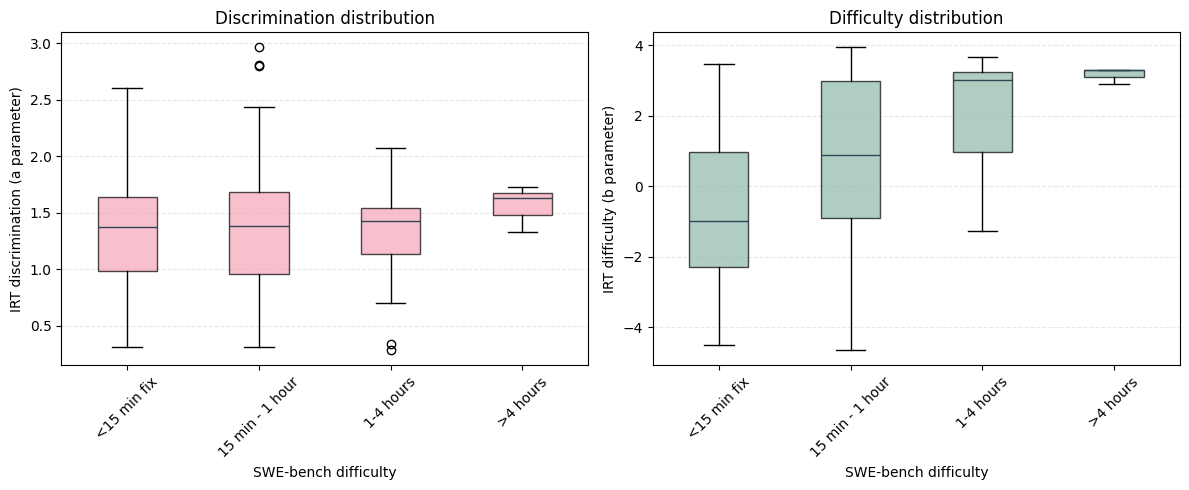

In [27]:
import matplotlib.pyplot as plt

if "a_by_difficulty" not in globals() or "b_by_difficulty" not in globals():
    raise RuntimeError("Run the averaging cell first to build parameter dictionaries")

ordered = globals().get("ordered_labels") or [label for label in difficulty_levels if label in b_by_difficulty]
a_box_data = [a_by_difficulty[label] for label in ordered]
b_box_data = [b_by_difficulty[label] for label in ordered]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

axes[0].boxplot(a_box_data, labels=ordered, vert=True, patch_artist=True,
                boxprops=dict(facecolor="#F6A4B7", alpha=0.7),
                medianprops=dict(color="#2F4858"))
axes[0].set_ylabel("IRT discrimination (a parameter)")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_title("Discrimination distribution")
axes[0].grid(axis="y", linestyle="--", alpha=0.3)
axes[0].tick_params(axis="x", rotation=45)

axes[1].boxplot(b_box_data, labels=ordered, vert=True, patch_artist=True,
                boxprops=dict(facecolor="#8FB9A8", alpha=0.7),
                medianprops=dict(color="#2F4858"))
axes[1].set_ylabel("IRT difficulty (b parameter)")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_title("Difficulty distribution")
axes[1].grid(axis="y", linestyle="--", alpha=0.3)
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()



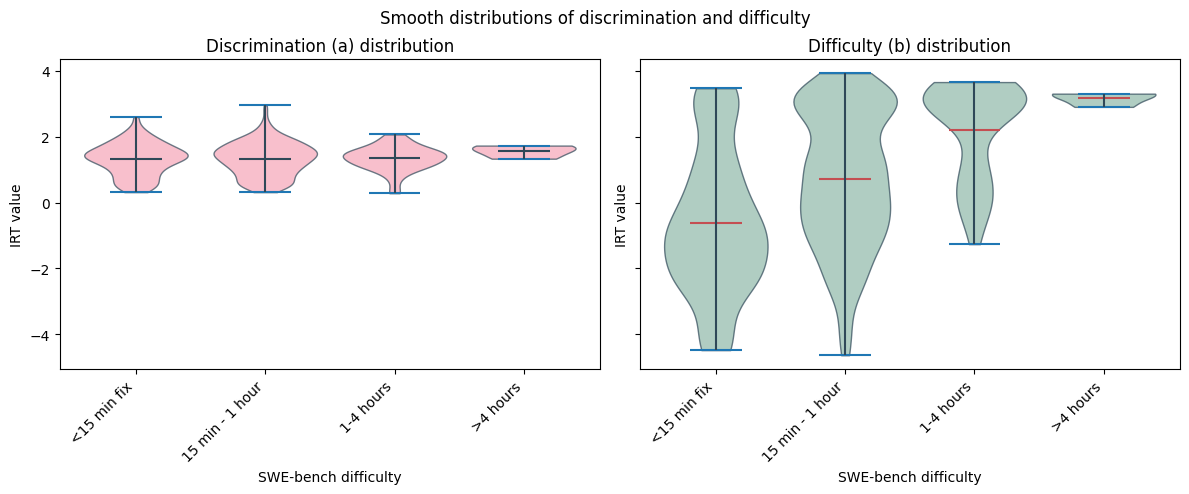

In [28]:
import matplotlib.pyplot as plt

if "a_by_difficulty" not in globals() or "b_by_difficulty" not in globals():
    raise RuntimeError("Run the averaging cell first to build parameter dictionaries")

ordered = globals().get("ordered_labels") or [label for label in difficulty_levels if label in b_by_difficulty]
a_violin_data = [a_by_difficulty[label] for label in ordered]
b_violin_data = [b_by_difficulty[label] for label in ordered]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

parts_a = axes[0].violinplot(a_violin_data, vert=True, showmeans=True, widths=0.8)
for pc in parts_a['bodies']:
    pc.set_facecolor("#F6A4B7")
    pc.set_edgecolor("#2F4858")
    pc.set_alpha(0.7)
parts_a['cbars'].set_color("#2F4858")
parts_a['cmeans'].set_color("#2F4858")
axes[0].set_xticks(range(1, len(ordered) + 1), ordered, rotation=45, ha="right")
axes[0].set_ylabel("IRT value")
axes[0].set_xlabel("SWE-bench difficulty")
axes[0].set_title("Discrimination (a) distribution")

parts_b = axes[1].violinplot(b_violin_data, vert=True, showmeans=True, widths=0.8)
for pc in parts_b['bodies']:
    pc.set_facecolor("#8FB9A8")
    pc.set_edgecolor("#2F4858")
    pc.set_alpha(0.7)
parts_b['cbars'].set_color("#2F4858")
parts_b['cmeans'].set_color("#C44E52")
axes[1].set_xticks(range(1, len(ordered) + 1), ordered, rotation=45, ha="right")
axes[1].set_ylabel("IRT value")
axes[1].set_xlabel("SWE-bench difficulty")
axes[1].set_title("Difficulty (b) distribution")

plt.suptitle("Smooth distributions of discrimination and difficulty")
plt.tight_layout()
plt.subplots_adjust(top=0.88)

